# Знакомство с pytorch (5 баллов)

In [1]:
import torch
import numpy as np
#!pip install scikit-learn==1.1

In [2]:
# numpy world

x = np.arange(16).reshape(4, 4)

print("X :\n %s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", np.dot(x, x.T))
print("mean over cols :\n%s" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s" % (np.cumsum(x, axis=0)))

X :
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]
X*X^T  :
 [[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
mean over cols :
[ 1.5  5.5  9.5 13.5]
cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]


In [3]:
# pytorch world

x = np.arange(16).reshape(4, 4)

x = torch.from_numpy(x).type(torch.FloatTensor) #or torch.arange(0,16).view(4,4)

print("X :\n%s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", torch.matmul(x, x.transpose(1, 0)))
print("mean over cols :\n", torch.mean(x, dim=-1))
print("cumsum of cols :\n", torch.cumsum(x, dim=0))

X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T  :
 tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols :
 tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


## NumPy vs Pytorch

Numpy и Pytorch не требуют описания статического графа вычислений.

Можно отлаживаться с помощью pdb или просто print.

API несколько различается:

```
x.reshape([1,2,8]) -> x.view(1,2,8)
x.sum(axis=-1) -> x.sum(dim=-1)
x.astype('int64') -> x.type(torch.int64)
```


Легко конвертировать между собой:

```
torch.from_numpy(npx) -- вернет Tensor
tt.numpy() -- вернет Numpy Array
```

Преобразовать тензор из одного числа в обычное питоновское число:
```
torch.tensor([1]).item() -> 1
```


Если что:
- смотрите документацию https://pytorch.org/docs/
- гуглите (Stackoverflow/tutorials)

Давайте кое что посчитаем

$$ x(t) = t - 1.5 * cos( 15 t) $$
$$ y(t) = t - 1.5 * sin( 16 t) $$


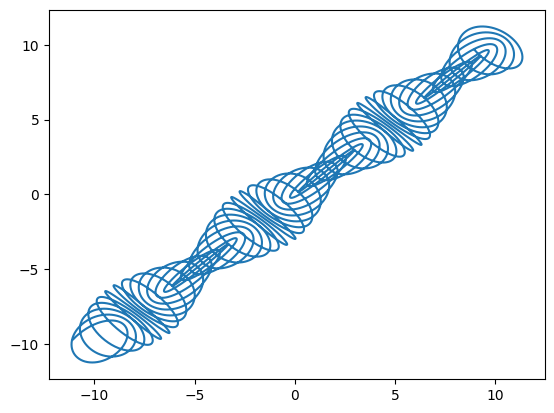

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

t = torch.linspace(-10, 10, steps = 10000)

# compute x(t) and y(t) as defined above
x = t - 1.5 * torch.cos(15 * t)
y = t - 1.5 * torch.sin(16 * t)

plt.plot(x.numpy(), y.numpy())

# Automatic gradients

У каждого тензора в Pytorch есть флаг `requires_grad`, который отвечает за автоматическое вычисление градиентов:

1. Создать переменную: `a = torch.tensor(..., requires_grad=True)`

2. Определить какую-нибудь дифференцируемую функцию `loss = whatever(a)`

3. Запросить обратный проход `loss.backward()`

4. Градиенты будут доступны в `a.grads`


Есть два важных отличия Pytorch от Theano/TF:

1. Функцию ошибки можно изменять динамически, например на каждом минибатче.

2. После вычисления `.backward()` градиенты сохраняются в `.grad` каждой задействованной переменной, при повторных вызовах градиенты суммируются. Это позволяет использовать несколько функций ошибок или виртуально увеличивать batch_size. Поэтому, после каждого шага оптимизатора градиенты стоит обнулять.



## Leaf vs Non-leaf Variable:
```
x = torch.tensor([1., 2., 3., 4.], requires_grad=True))  # leaf tensor
y = x + 1  # not a leaf variable
```

Градиенты будут сохранены и доступны для использования только для `leaf tensor`.
Такое поведение по-умолчанию сделано ради экономии памяти. Все тензоры с флагом `requires_grad = False` считаются`leaf tensors` по умолчанию.


Обратите внимание, что вычисление градиентов работает только для тензоров с вещественным типом данных:

In [5]:
# will not work
x = torch.tensor([1., 2., 3., 4.], requires_grad=True)


Чтобы выставить флаг `requires_grad=False` и выключить автоматическое вычисление градиентов для нескольких тензоров, можно использовать `with torch.no_grad()` или `detach`:

In [6]:
x = torch.tensor([1.], requires_grad=True)
y = x**2
print(x.requires_grad)
print(y.requires_grad)

with torch.no_grad():
    z = torch.exp(x)
    print(z.requires_grad)

# detach from the graph
w = torch.log(x).detach()
print(w.requires_grad)

True
True
False
False


Рассмотрим пример линейной регрессии на датасете Boston

c:\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np

        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fun

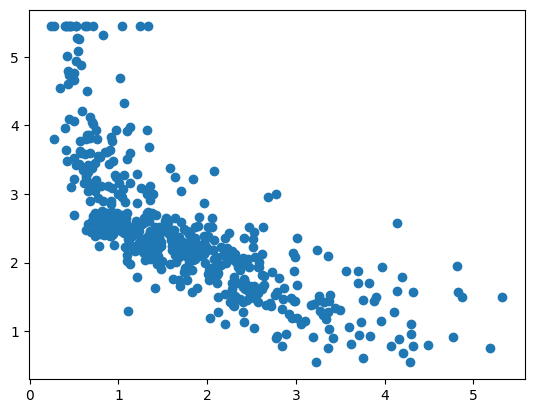

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

x, y = load_boston(return_X_y=True)

#select one column for simplicity.
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

plt.scatter(x, y)

In [8]:
# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# data tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# все тензоры являются leaf-tensors
# x и y не требуют вычисления градиентов
for vv in [w, b, x, y]:
    print(vv.is_leaf, vv.requires_grad)

True True
True True
True False
True False


# Линейная регрессия c помощью pytroch

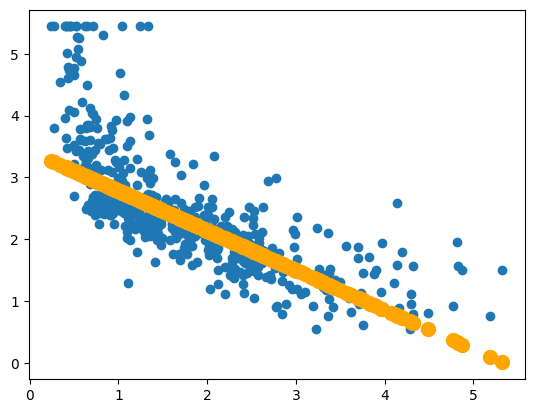

loss =  0.9297537


In [9]:
from IPython.display import clear_output

for i in range(1000):

    #запишите формулу линейной регрессии с помощью w, x, b
    y_pred = w * x + b
    #посчитайте MSE с помощью torch.mean, y и переменной в которую вы записали результат строкой выше
    loss = torch.mean(abs(y_pred - y)*2)

    # backprop
    loss.backward()

    # вот так руками можно применять градиенты
    w.data -= 0.05 * w.grad.data
    b.data -= 0.05 * b.grad.data

    # обнуляем градиенты руками
    w.grad.data.zero_()
    b.grad.data.zero_()

    # строим графики
    if (i+1)%5==0:
        clear_output(True)
        plt.scatter(x.data.numpy(), y.data.numpy())
        plt.scatter(x.data.numpy(), y_pred.data.numpy(), color='orange', linewidth=5)
        plt.show()

        print("loss = ", loss.data.numpy())
        if loss.data.numpy() < 0.5:
            print("Done!")
            break

# Optimizers

В этом примере мы пользовались простым правилом для градиентного спуска:
  
$$\theta^{n+1} = \theta^{n} - \alpha \nabla_{\theta}L$$


Единственным параметром в нем является $\alpha$ -- это `learning_rate`.

На практике часто используют различные модификации (например _Momentum_):

$$\theta^{n+1} = \theta^{n} - U^{n}\\
U^{n} = \gamma U^{n-1} + \alpha \nabla_{\theta}(L)
$$

Хороший обзор алгоритмов оптимизации для сетей можно посмотреть [тут](http://ruder.io/optimizing-gradient-descent/).



Pytorch предоставляет практически все широкораспространненные оптимизаторы:    
http://pytorch.org/docs/master/optim.html




Оптимизаторы удобны в использовании:

- требуется указать список переменных для оптимизации
- `opt.step()` применяет `update` ($U^{n}$) к весам
- `opt.zero_grad()` сбрасывает градиенты





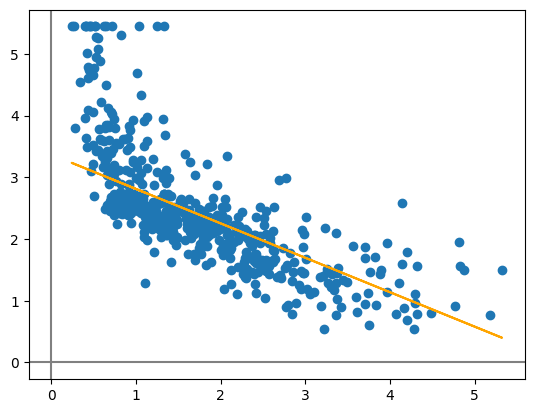

loss =  0.49351760745048523
Done!


In [10]:
# get data
x, y = load_boston(return_X_y=True)
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

# data tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# define optimizer
opt = torch.optim.RMSprop([w, b], lr=0.1)

for i in range(100):
    # посчитайте ошибку
    y_pred = w * x + b
    loss = torch.mean((y_pred - y) ** 2)
    # backprop and gradient descent но теперь не руками а с помощью оптимизатора и функци описанных выше
    opt.zero_grad()
    loss.backward()
    opt.step()
    #the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), y_pred.data.numpy(), color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

# Немного более сложных тензоров (2 балла)

$$\rho(\theta) = (1 + 0.9 \cdot cos (8 \cdot \theta) ) \cdot (1 + 0.1 \cdot cos(24 \cdot \theta)) \cdot (0.9 + 0.05 \cdot cos(200 \cdot \theta)) \cdot (1 + sin(\theta))$$

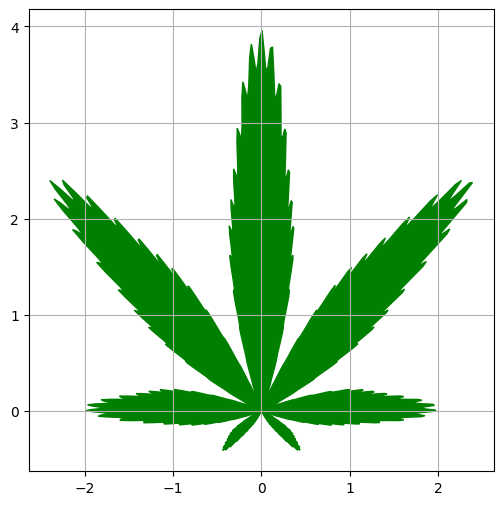

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
theta = torch.linspace(- np.pi, np.pi, steps=1000)

# compute rho(theta) as per formula above
rho = (1 + 0.9 * torch.cos(8 * theta)) * \
      (1 + 0.1 * torch.cos(24 * theta)) * \
      (0.9 + 0.05 * torch.cos(200 * theta)) * \
      (1 + torch.sin(theta))

x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

## Highlevel-API (5 баллов)

При работе с нейронными сетями становится неудобно контролировать переменные с весами по-отдельности. Pytorch предоставляет высокоуровневый API для моделей http://pytorch.org/docs/master/nn.html#torch.nn.Module.


Чтобы воспользоваться моделью необходимо отнаследоваться от torch.nn.Module, определить слои и описать `forward`, `backward` будет вычислен автоматически.


Для демонстрации воспользуемся MNIST'ом.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


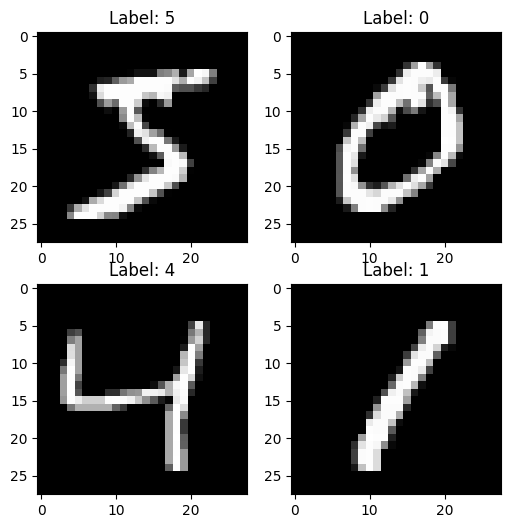

In [12]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

from util import load_mnist
import matplotlib.pyplot as plt
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray')

А вот так уже в почти приличном мире описывают сетки. Приличный мир будет в следующей дз. Здесь строится сетка - классификатор

In [13]:
# Higher-level API:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, hidden_size=40):
        super(Net, self).__init__()
        # создайте слои нейронки nn.Linear
        self.fc1 = nn.Linear(X_train.shape[1], hidden_size) # размером X_train.shape[1], hidden_size - входной слой
        self.fc2 = nn.Linear(hidden_size, hidden_size) # hidden_size на hidden_size - скрытый слой
        self.fc3 = nn.Linear(hidden_size, 10) # подумайте какой размер слоя должен быть на выходе

    def forward(self, x):
        # применяем ReLU к внутренним слоям
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=-1)


In [14]:
# model interface:
model = Net()
tt = torch.from_numpy(X_train[:10, :].astype(np.float32))
output = model(tt)

print('Model outputs: \n', output)
probs = torch.softmax(output, dim=-1)
print('Probs: \n', probs)

pred = torch.argmax(probs, dim=-1, keepdim=True)
print('Pred: \n', pred.data.numpy())
print('Truth: \n', y_train[:10])

Model outputs: 
 tensor([[-2.2084, -2.2125, -2.2506, -2.3358, -2.3183, -2.4449, -2.3607, -2.2505,
         -2.2944, -2.3759],
        [-2.2434, -2.2013, -2.2341, -2.3077, -2.3277, -2.4514, -2.3329, -2.3057,
         -2.2935, -2.3502],
        [-2.2392, -2.1836, -2.1974, -2.3267, -2.3272, -2.4822, -2.3710, -2.2965,
         -2.3199, -2.3157],
        [-2.2318, -2.2003, -2.2406, -2.2990, -2.2968, -2.4375, -2.4019, -2.3162,
         -2.2952, -2.3305],
        [-2.2230, -2.1996, -2.2465, -2.3328, -2.2972, -2.4545, -2.3563, -2.3132,
         -2.2962, -2.3302],
        [-2.2346, -2.1824, -2.2322, -2.3078, -2.3101, -2.4508, -2.3675, -2.2819,
         -2.3148, -2.3712],
        [-2.2145, -2.1968, -2.2469, -2.3484, -2.3165, -2.4886, -2.3882, -2.2589,
         -2.2922, -2.3084],
        [-2.2569, -2.1965, -2.2160, -2.3226, -2.3591, -2.4248, -2.3517, -2.2817,
         -2.2761, -2.3637],
        [-2.2332, -2.1989, -2.2325, -2.3391, -2.3139, -2.4744, -2.3878, -2.2819,
         -2.2829, -2.3105],
  

Тренировка сети

Для тренировки сети нам требуется
- итератор по данным
- функция тренировки (прогон по данным, вычисление и применение градиентов)
- функция валидации (прогон по тестовым данным, вычисление метрик)

In [15]:
from IPython.display import clear_output
from tqdm import trange

# функция для итераций по минибатчам
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

Обучаем также как и в случае линейной регрессии. Предсказываем результат по данным. Обучаем. В данном случае только функционал ошибки другой, не заморачивайтесь об этом. О вспомогательных функциях тоже не заморачивайтесь. Тут только надо знать что нейросети обучают батчами

In [16]:
def train(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()

        loss = loss.item()
        loss_log.append(loss)
    return loss_log


def test(model):
    loss_log = []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        output = model(data)
        loss = F.nll_loss(output, target)
        loss = loss.item()
        loss_log.append(loss)
    return loss_log


In [17]:
def plot_history(train_history, val_history, title='loss'):
    clear_output(True)
    step = len(train_history) / len(val_history)
    plt.figure()
    plt.axhline(0, color='gray')
    plt.axvline(0, color='gray')
    plt.plot(np.arange(len(train_history)), train_history, color='orange',zorder=1)
    plt.scatter(np.arange(step, len(val_history) * step + step, step), val_history,zorder=2)
    plt.show()


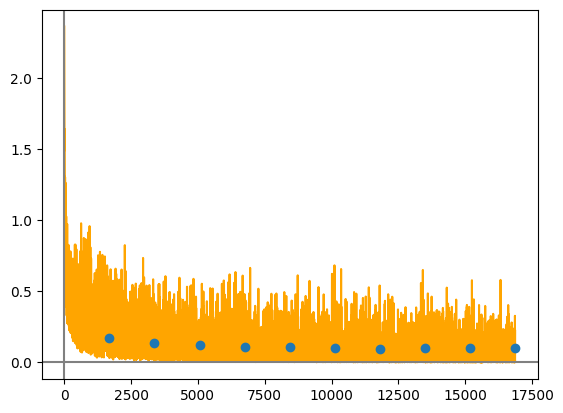

In [18]:
train_log = []
val_log = []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32

for epoch in range(10):
    train_loss = train(model, opt, batchsize=batchsize)
    train_log.extend(train_loss)

    val_loss = np.mean(test(model))
    val_log.append(val_loss)
    plot_history(train_log, val_log)


## Метрики

Logloss -- величина, которую трудно интерпретировать.
Для отслеживания тренировки и сравнения моделей удобнее наблюдать за интерпретируемыми метриками, например точностью (accuracy)



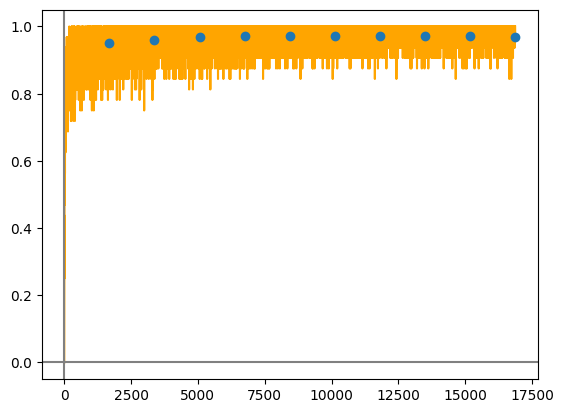

In [20]:
def train(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output, target)

        # compute gradients
        # make a step
        loss.backward()
        optimizer.step()

        loss = loss.item()
        loss_log.append(loss)

        probs = torch.softmax(output, dim=-1)
        pred = torch.argmax(probs, dim=-1, keepdim=True)
        acc_log.append(np.mean(pred.detach().numpy().flatten() == y_batch))
    return loss_log, acc_log


def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        output = model(data)
        loss = F.nll_loss(output, target)
        loss = loss.item()
        loss_log.append(loss)

        probs = torch.softmax(output, dim=-1)
        pred = torch.argmax(probs, dim=-1, keepdim=True)
        acc_log.append(np.mean(pred.detach().numpy().flatten() == y_batch))
    return loss_log, acc_log


train_log, train_acc_log = [], []
val_log, val_acc_log = [], []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32


train_log = []
val_log = []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32

for epoch in range(10):
    train_loss, train_acc = train(model, opt, batchsize=batchsize)
    train_log.extend(train_acc)

    val_loss, val_acc = test(model)
    val_log.append(np.mean(val_acc))

    plot_history(train_log, val_log, title = 'acc')
